In [6]:
import statsmodels
from statsmodels.tsa.arima_model import ARIMA
# from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import acf, ccf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics import utils
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
stock = pd.read_csv('NSE-TATAGLOBAL11.csv')

In [8]:
# stock.index = pd.date_range(start='10/08/2013', end='10/08/2018',freq='B')
# stock.set_index(pd.DatetimeIndex(stock['Date']), inplace=True, drop=True,freq='A')
# del stock['Date']
stock['Date'] = pd.to_datetime(stock.Date,format='%Y-%m-%d')
stock.index = stock['Date']
stock = stock.sort_index()
stock.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
Date,,,,,,,,
2013-10-08,2013-10-08,157.00,157.80,155.20,155.8,155.80,1720413.0,2688.94
2013-10-09,2013-10-09,155.70,158.20,154.15,155.3,155.55,2049580.0,3204.49
2013-10-10,2013-10-10,156.00,160.80,155.85,160.3,160.15,3124853.0,4978.80
2013-10-11,2013-10-11,161.15,163.45,159.00,159.8,160.05,1880046.0,3030.76
2013-10-14,2013-10-14,160.85,161.45,157.70,159.3,159.45,1281419.0,2039.09


In [39]:
train_data = stock.iloc[:int(0.8*len(stock))]
valid_data = stock.iloc[int(0.8*len(stock)):int(0.9*len(stock))]
test_data = stock.iloc[int(0.9*len(stock)):]


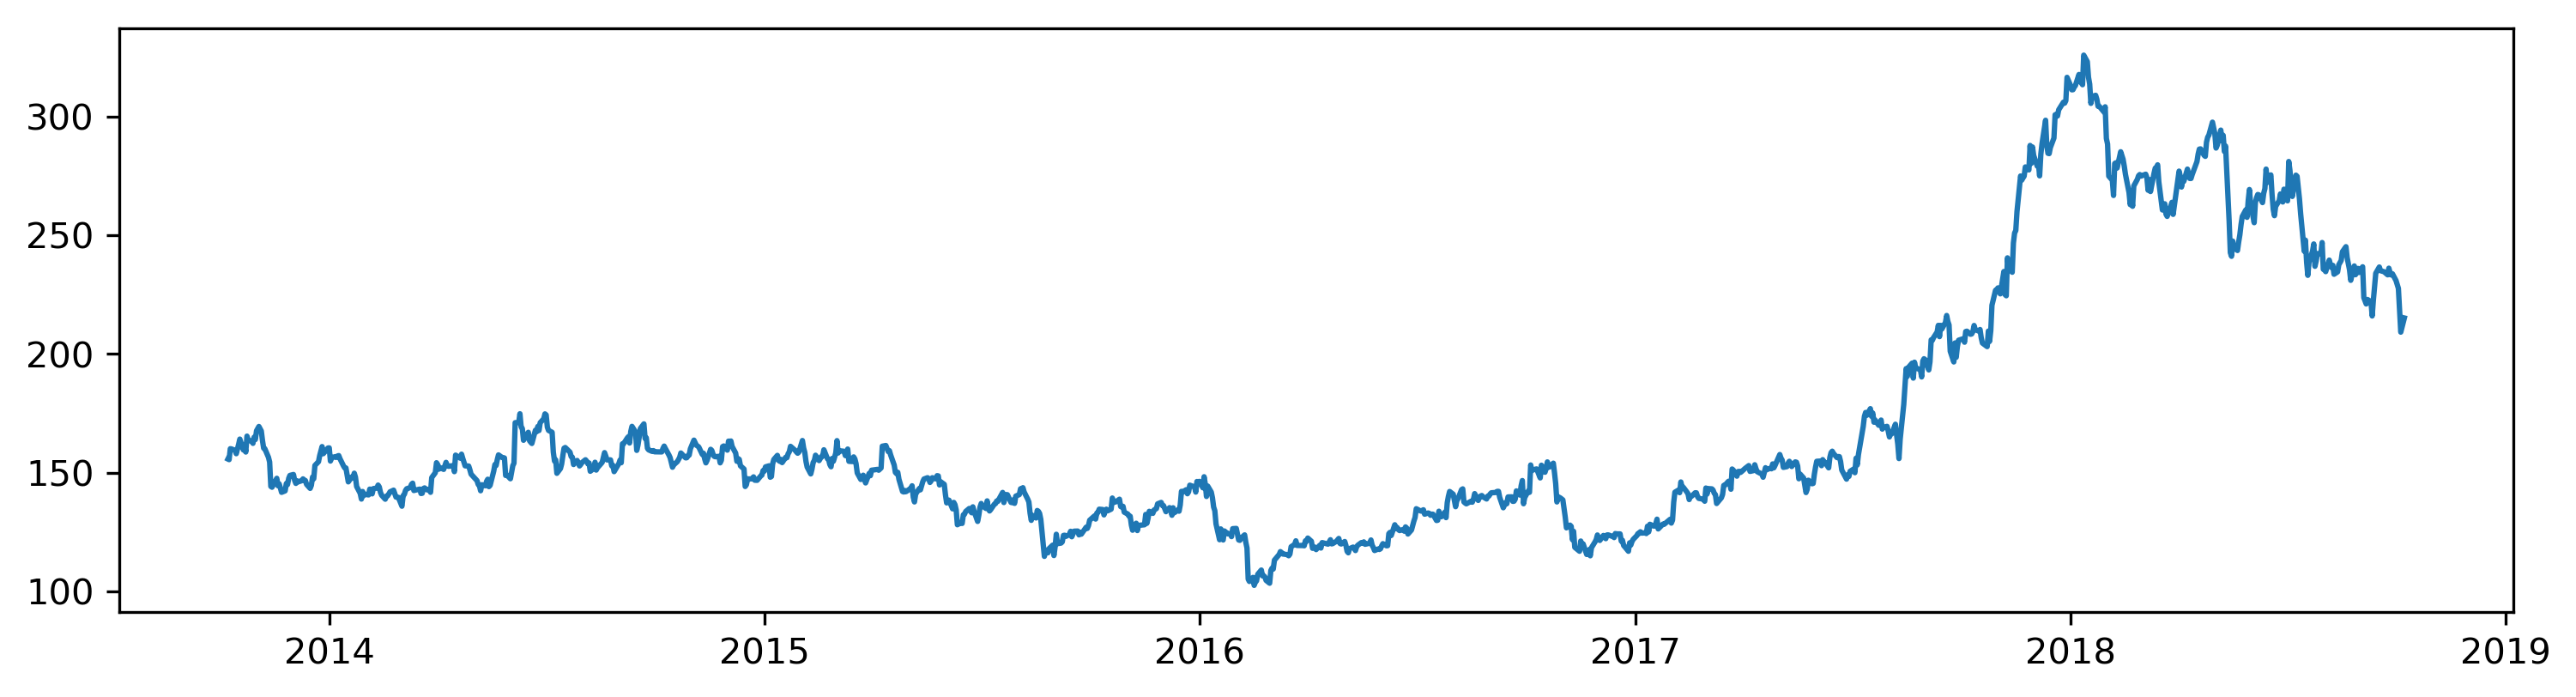

In [9]:
#plot
plt.figure(figsize=(12,3),dpi=300)
plt.plot(stock['Close'], label='Close Price history')
# plt.savefig('stock')

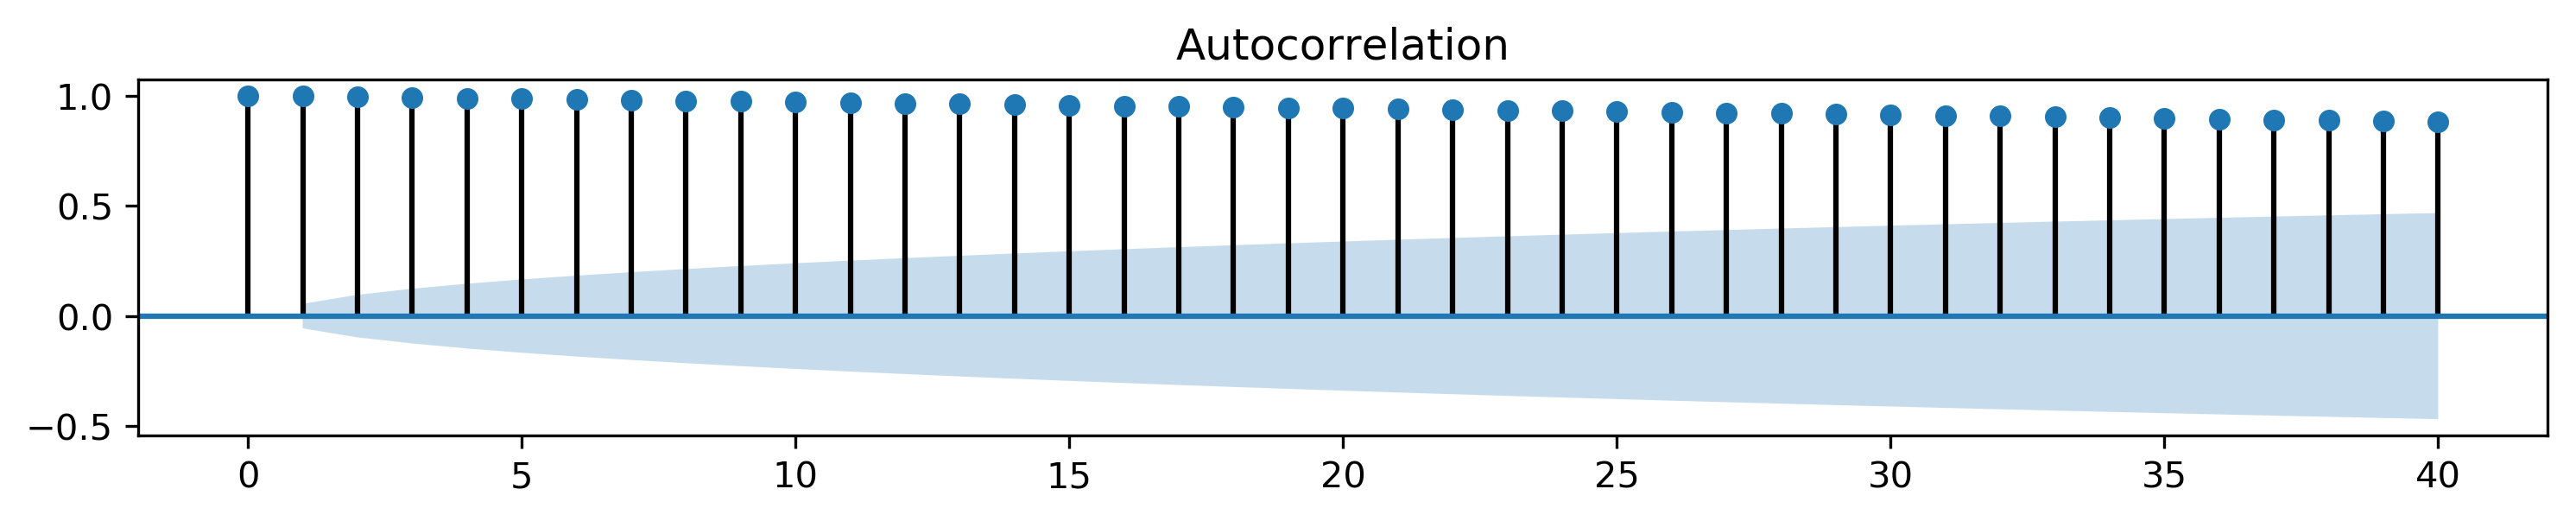

In [527]:
fig = plt.figure(figsize=(12,4),dpi=300)
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(stock.Close, lags=40, ax=ax1)

plt.savefig('stock_acf')
# plt.show()

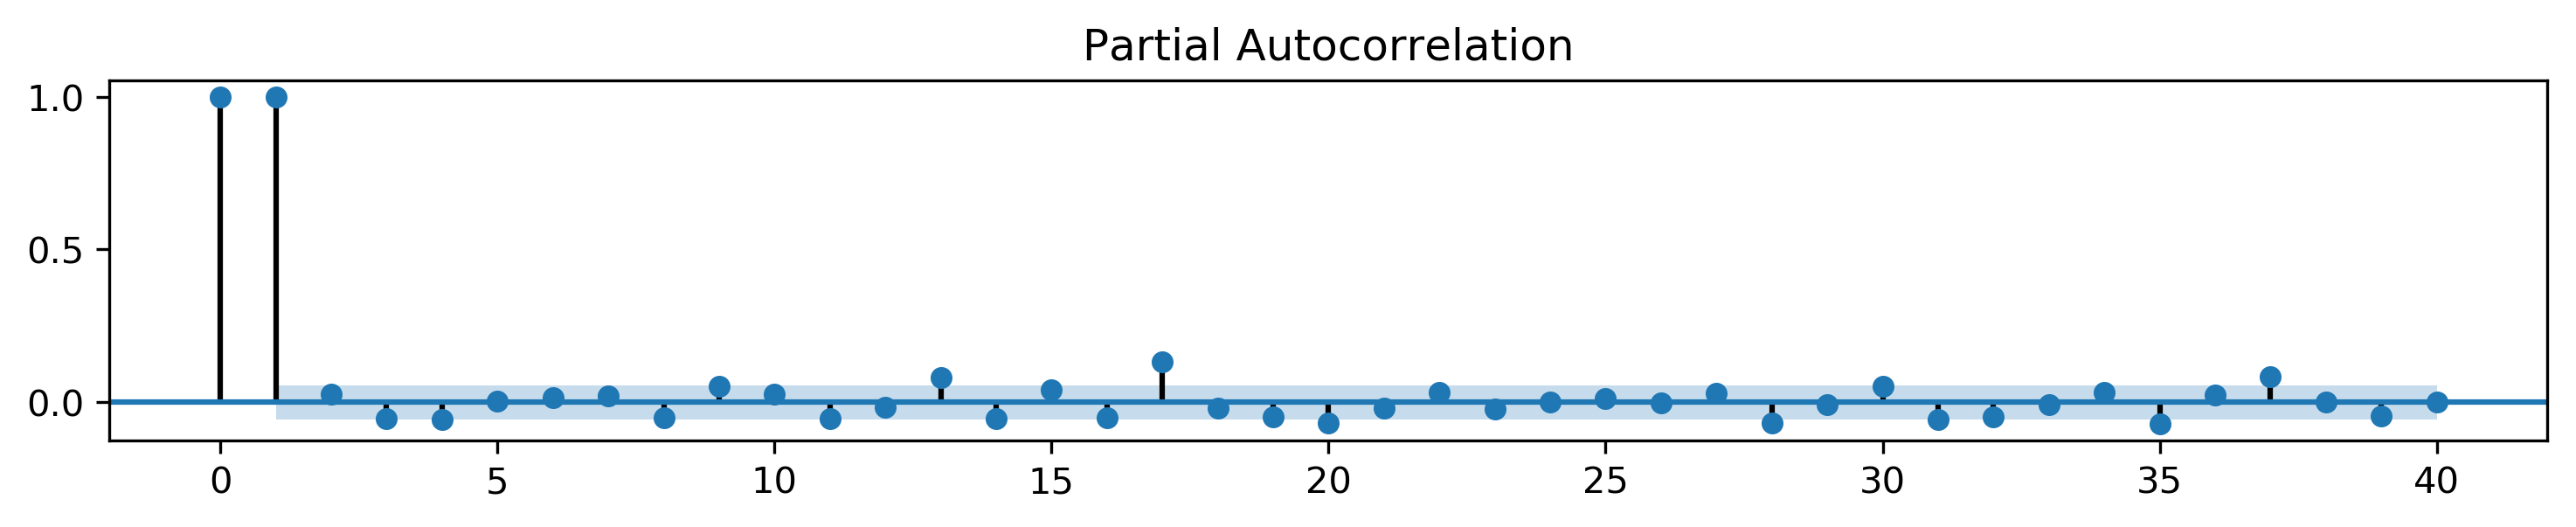

In [542]:
fig = plt.figure(figsize=(12,4),dpi=300)
ax2 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_pacf(stock.Close, lags=40, ax=ax2)
plt.savefig('stock_pacf')


In [76]:
stock_log_diff = np.log(stock.Close).diff().dropna()

In [16]:
stock_log = pd.DataFrame(np.log(stock.Close))

In [25]:
train_log = stock_log.iloc[:int(0.8*len(stock_log))]
valid_log = stock_log.iloc[int(0.8*len(stock_log)):int(0.9*len(stock_log))]
test_log = stock_log.iloc[int(0.9*len(stock_log)):]


In [482]:
# a = [3,4,5,6,7]
# b = pd.Series(np.log(a))
# c = b.diff()
# b_ = [b[0]]
# for diff in c[1:]:
#     b_.append(b_[-1]+diff)
# a_ = [np.e**i for i in b_]
# a_

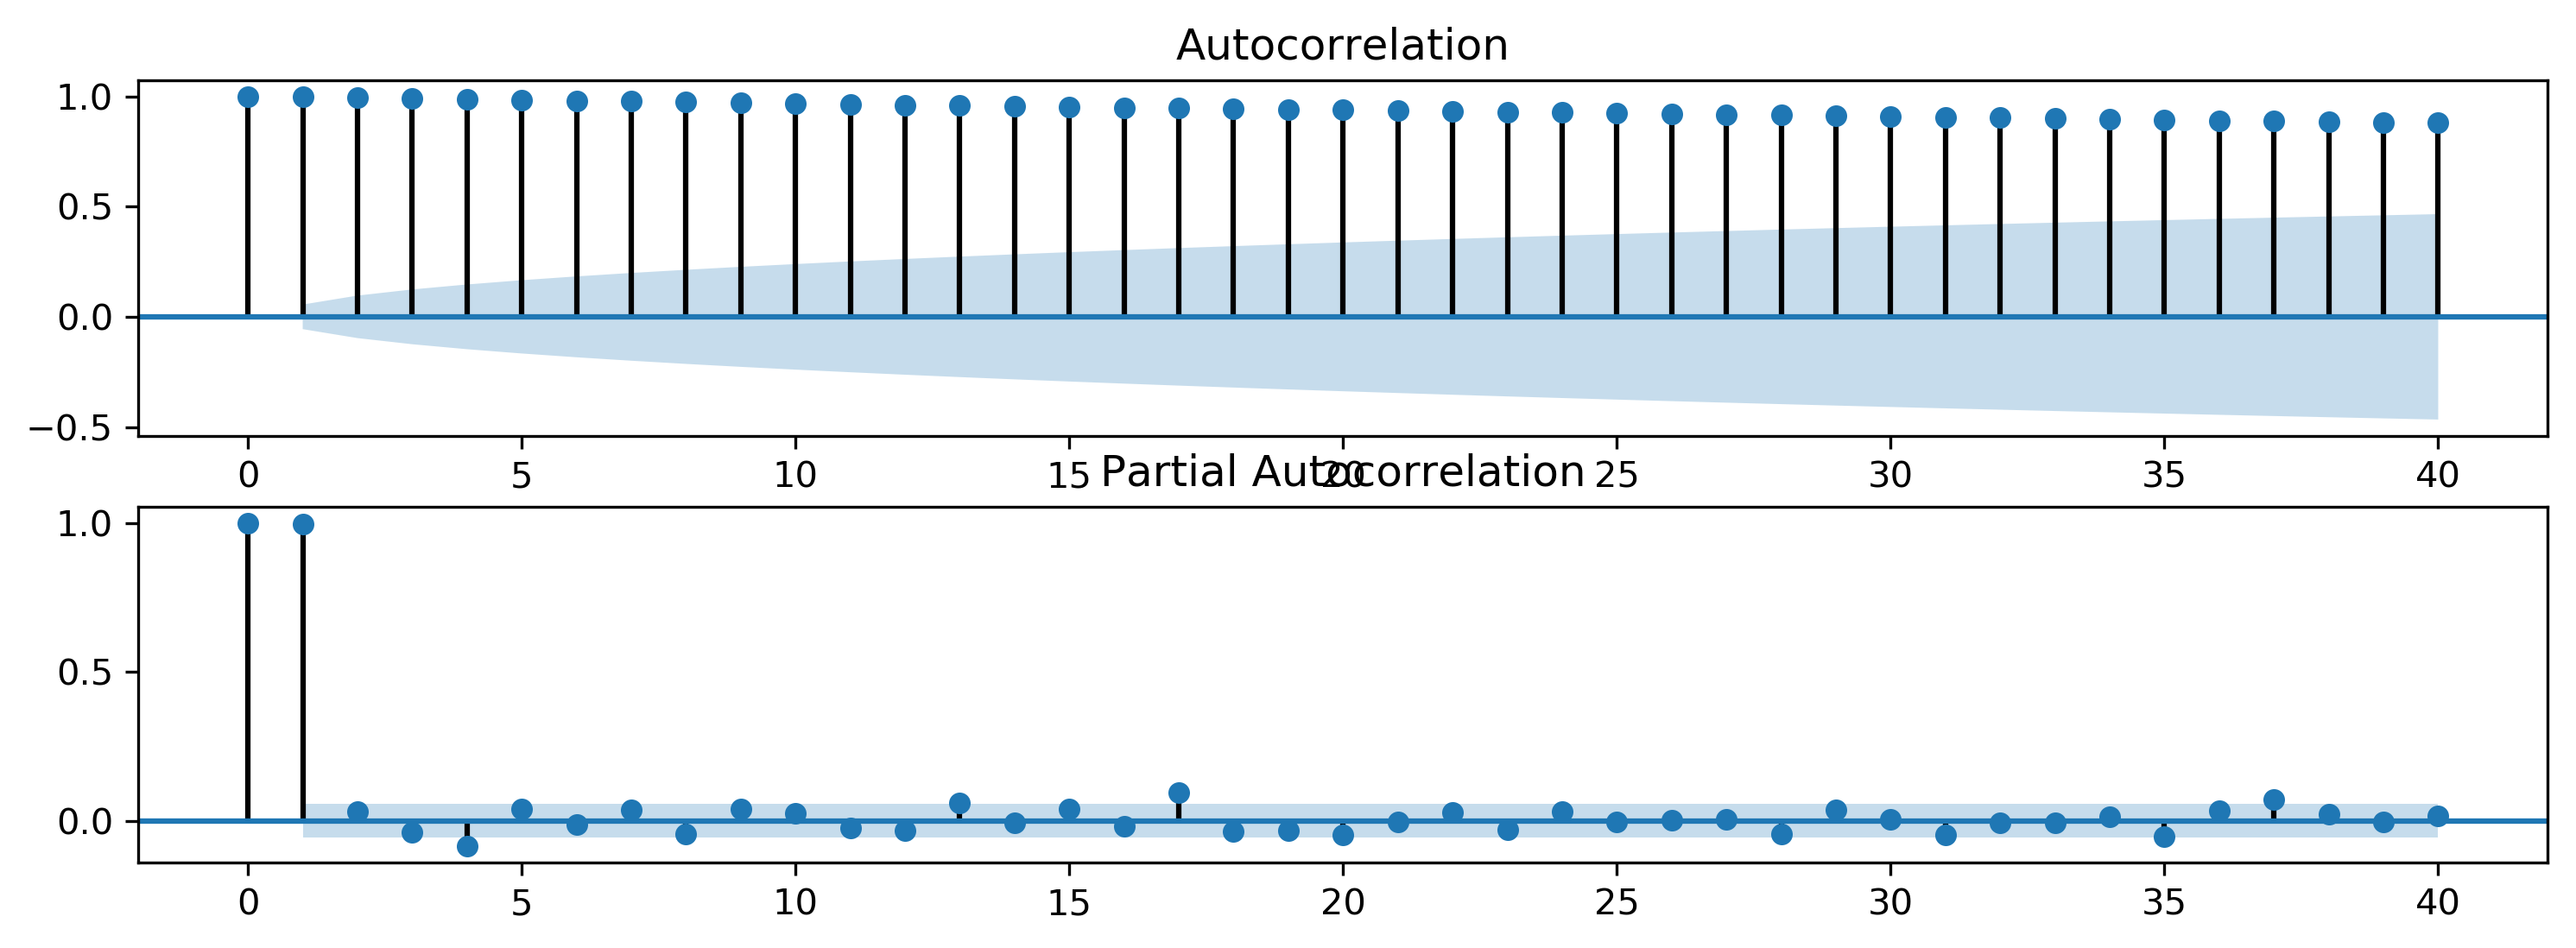

In [561]:
fig = plt.figure(figsize=(12,4),dpi=300)
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(stock_log, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(stock_log, lags=40, ax=ax2)


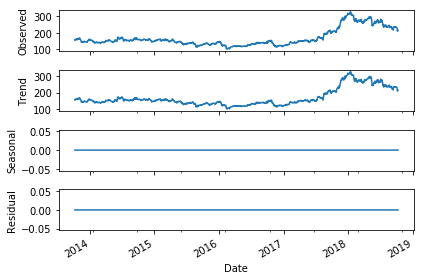

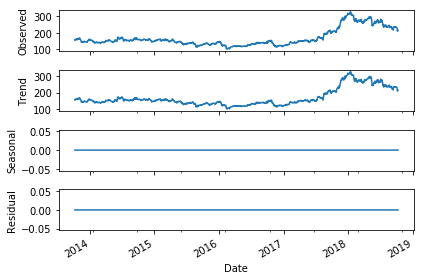

In [579]:
from statsmodels.tsa.seasonal import seasonal_decompose
seasonal_decompose(pd.DataFrame(stock.Close),freq=1).plot()

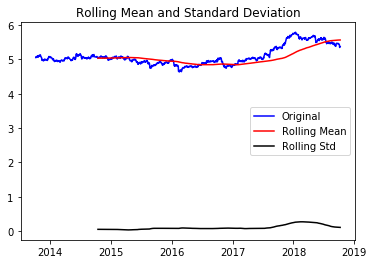

Results of dickey fuller test
Test Statistics                  -1.075688
p-value                           0.724669
No. of lags used                  0.000000
Number of observations used    1234.000000
critical value (1%)              -3.435660
critical value (5%)              -2.863885
critical value (10%)             -2.568019
dtype: float64


In [33]:
from statsmodels.tsa.stattools import adfuller


#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(252).mean()
    rolstd = timeseries.rolling(252).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    #null hypo: data is non-stationary
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(stock_log.Close)

In [64]:
# model = ARIMA(train_log_diff, order=(0, 1, 1)).fit(disp=-1) 
model = ARIMA(train_log, order=(2, 1, 0)).fit(disp=-1) 
# model = sm.tsa.ARMA(train_log_diff, (1,1)).fit(disp=False)


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [65]:
pred = model.forecast(123)[0]
# pred_back = [np.e**i for i in pred]

In [66]:
pred_back = [np.e**i for i in pred]
s = pd.Series(pred_back,index = valid_data.index)

In [67]:
rmse = math.sqrt(mean_squared_error(valid_data.Close, pred_back))
print('RMSE: '+str(rmse))
# smape = np.mean(np.abs(pred_back - test_data.Close)/(np.abs(test_data.Close)+np.abs(pred_back))/2)
smape = np.mean(2*np.abs(pred_back-valid_data.Close)/(np.abs(pred_back)+np.abs(valid_data.Close)))
print('SMAPE: '+str(smape))

RMSE: 66.96305771063473
SMAPE: 0.24004940432121963


In [68]:
pred_test = model.forecast(124)[0]
pred_back_test = [np.e**i for i in pred_test]

In [38]:
# # pred = model.forecast(235)[0]
# pred = model.predict(1000,1234)
# pred_ = [np.log(220)]
# for diff in pred[1:]:
#     pred_.append(pred_[-1]+diff)
# pred_back = [np.e**i for i in pred_]

# # pred_back

In [69]:
# pred = model.forecast(235)[0]
# s = pd.Series(pred,index = test_data.index)
s = pd.Series(pred_back_test,index = test_data.index)

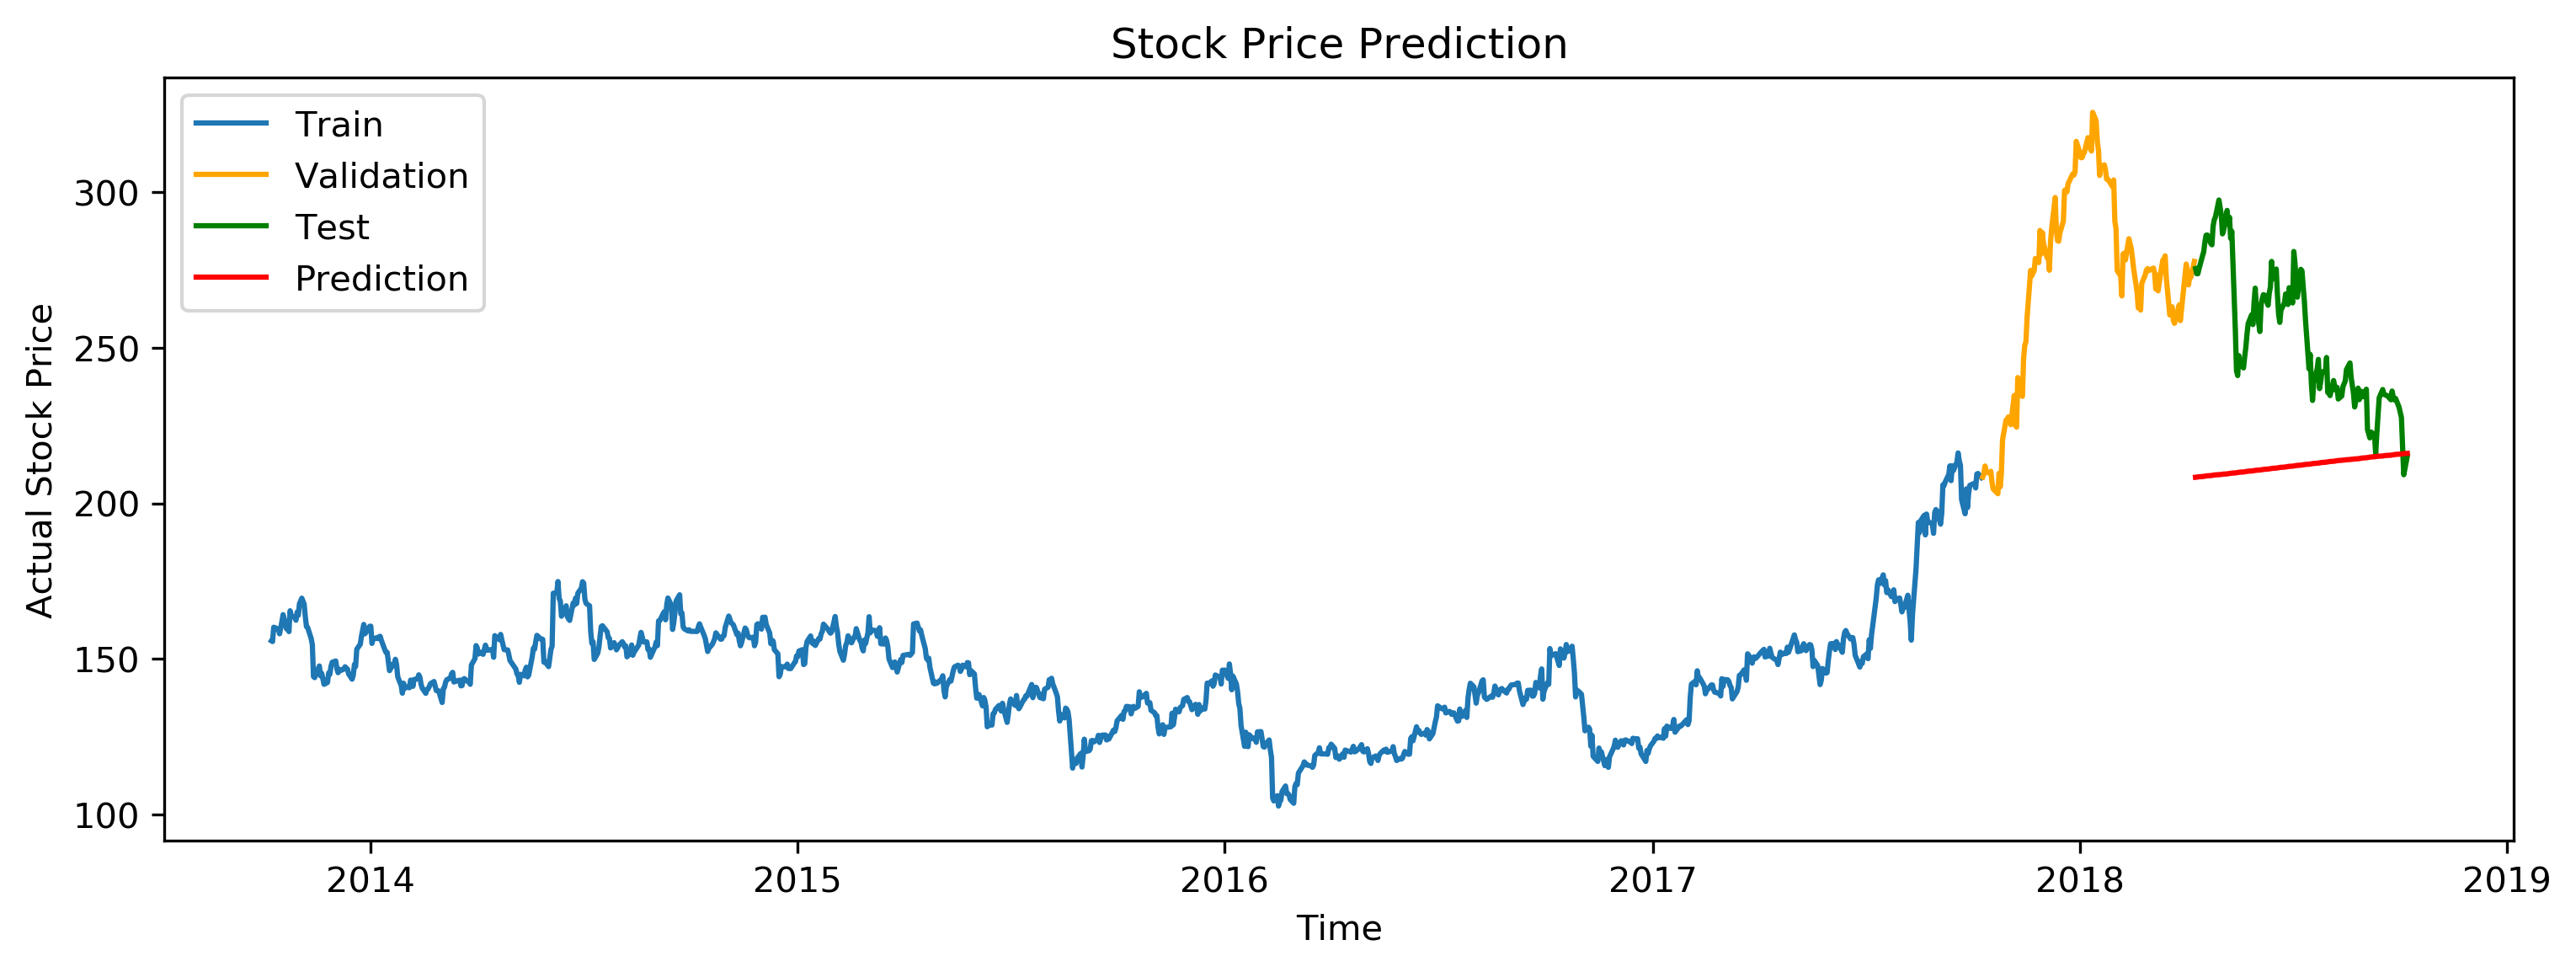

In [73]:

plt.figure(figsize=(12,4), dpi=300)
plt.plot(train_data.Close, label='Train')
plt.plot(valid_data.Close, color = 'orange', label='Validation')
plt.plot(test_data.Close, color = 'green', label='Test')
plt.plot(s, color = 'red',label='Prediction')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=10)
plt.savefig('stock_pred')
plt.show()

In [71]:

# mse = mean_squared_error(test_data.Close, fc)
# print('MSE: '+str(mse))
# mae = mean_absolute_error(test_data.Close, fc)
# print('MAE: '+str(mae))
rmse_test = math.sqrt(mean_squared_error(test_data.Close, pred_back_test))
print('RMSE: '+str(rmse_test))
# smape = np.mean(np.abs(pred_back - test_data.Close)/(np.abs(test_data.Close)+np.abs(pred_back))/2)
smape_test = np.mean(2*np.abs(pred_back_test-test_data.Close)/(np.abs(pred_back_test)+np.abs(test_data.Close)))
print('SMAPE: '+str(smape_test))

RMSE: 48.00275346268796
SMAPE: 0.17623195495861663


In [605]:
l = [np.abs(test_data.Close.tolist()[i]-pred_back[i]) for i in range(len(pred_back))]

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """


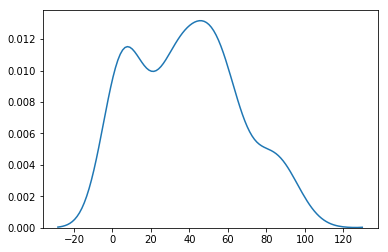

In [607]:
import seaborn as sns
sns.distplot(l, hist = False)